In [ ]:
import random
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from prophet import Prophet
import re
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [ ]:
drive_path = "/content/drive/MyDrive/데이터 경진대회/제주 특산물 가격 예측"
train_data_path = drive_path + "/train.csv"
test_data_path = drive_path + "/test.csv"
sample_submission_path = drive_path + "/sample_submission.csv"

In [ ]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [ ]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])

In [ ]:
category_list = train_df["ID"].str.replace(r'_\d{8}$', '', regex=True).unique()

In [ ]:
def handle_data_to_prophet(df) :
  transformed_df = df[["ID", "timestamp", "price(원/kg)"]]
  transformed_df["ID"] = transformed_df["ID"].str.replace(r'_\d{8}$', '', regex=True)
  transformed_df = transformed_df.rename(columns={'timestamp': 'ds', 'price(원/kg)': 'y'})
  return transformed_df.copy()

In [ ]:
prophet_train_data = handle_data_to_prophet(train_df)

In [ ]:
prophet_train_data.head(5)

,ID,ds,y
0,TG_A_J,2019-01-01,0.0
1,TG_A_J,2019-01-02,0.0
2,TG_A_J,2019-01-03,1728.0
3,TG_A_J,2019-01-04,1408.0
4,TG_A_J,2019-01-05,1250.0


### 해당 날짜의 y 데이터가 0인지 아닌지에 대한 판단 여부

In [ ]:
non_zero_train = prophet_train_data.copy()

In [ ]:
non_zero_train.loc[non_zero_train["y"] > 0, "y"] = 1

In [ ]:
non_zero_train.head(5)

,ID,ds,y
0,TG_A_J,2019-01-01,0.0
1,TG_A_J,2019-01-02,0.0
2,TG_A_J,2019-01-03,1.0
3,TG_A_J,2019-01-04,1.0
4,TG_A_J,2019-01-05,1.0


In [ ]:
non_zero_prophet_map = {}

In [ ]:
category = "TG_A_J"
main_model = Prophet()
current_category_train_x = non_zero_train[non_zero_train["ID"] == category].drop(columns=["ID"]).sort_values("ds")
non_zero_prophet_map[category] = main_model.fit(current_category_train_x)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjydeo82b/_1do5awh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjydeo82b/kbibrt5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59045', 'data', 'file=/tmp/tmpjydeo82b/_1do5awh.json', 'init=/tmp/tmpjydeo82b/kbibrt5r.json', 'output', 'file=/tmp/tmpjydeo82b/prophet_modelgqo242p0/prophet_model-20231110142014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:20:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:20:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


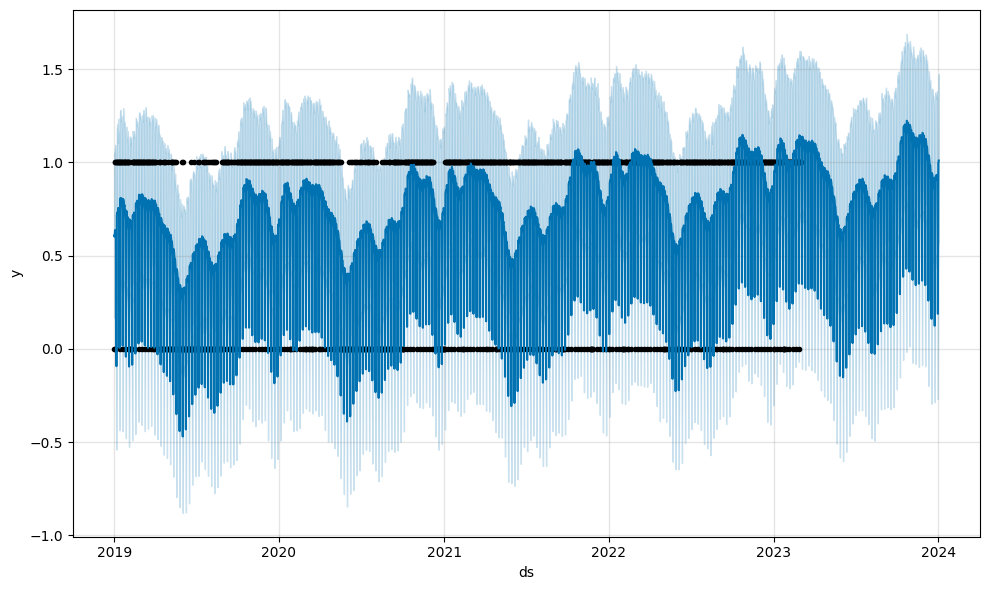

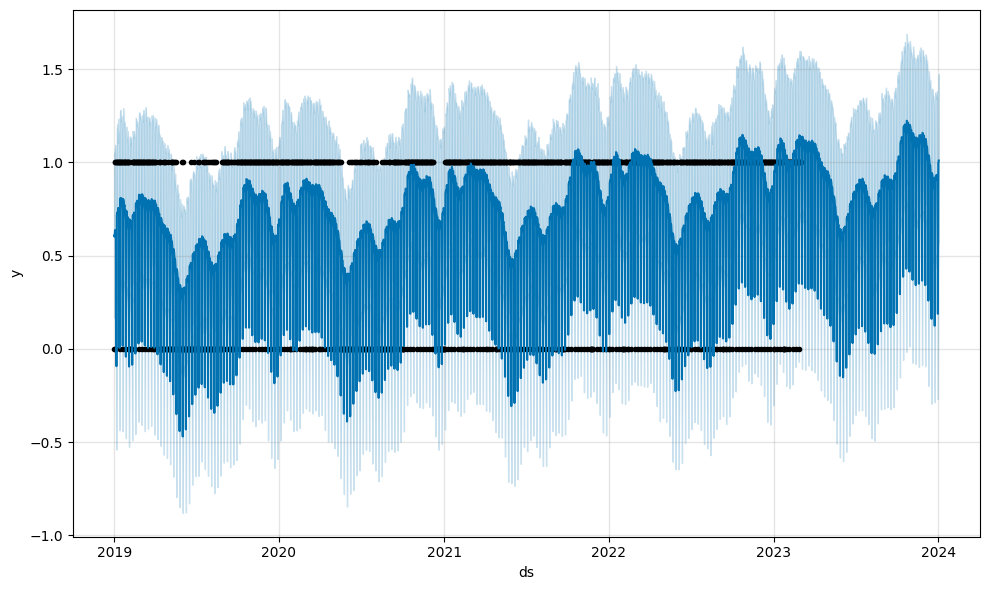

In [ ]:
test_model = non_zero_prophet_map["TG_A_J"]
future = test_model.make_future_dataframe(periods=305)
forecast = test_model.predict(future)
test_model.plot(forecast)

prophet의 경우, 이진 데이터에 대한 시계열 탐색을 수행하기에는 적합하지 않은 방식이라 판단

### non zero 탐색 모델 구성 2차 시도

In [ ]:
import datetime

In [ ]:
data = train_df.copy()

In [ ]:
data["day of week"] = data["timestamp"].dt.dayofweek
data["month"] = data["timestamp"].dt.month

In [ ]:
data = data[["ID", "timestamp", "price(원/kg)", "day of week", "month"]]
data["ID"] = data["ID"].str.replace(r'_\d{8}$', '', regex=True)
data = data.rename(columns={'timestamp': 'ds', 'price(원/kg)': 'y', 'day of week' : 'day'})
data.loc[data["y"] > 0, "y"] = 1

In [ ]:
data.head(5)

,ID,ds,y,day,month
0,TG_A_J,2019-01-01,0.0,1,1
1,TG_A_J,2019-01-02,0.0,2,1
2,TG_A_J,2019-01-03,1.0,3,1
3,TG_A_J,2019-01-04,1.0,4,1
4,TG_A_J,2019-01-05,1.0,5,1


In [ ]:
category_list

array(['TG_A_J', 'TG_A_S', 'TG_B_J', 'TG_B_S', 'TG_C_J', 'TG_C_S',
       'TG_D_J', 'TG_D_S', 'TG_E_J', 'TG_E_S', 'CR_A_J', 'CR_B_J',
       'CR_C_J', 'CR_D_J', 'CR_D_S', 'CR_E_J', 'CR_E_S', 'CB_A_J',
       'CB_A_S', 'CB_D_J', 'CB_E_J', 'RD_A_J', 'RD_A_S', 'RD_C_S',
       'RD_D_J', 'RD_D_S', 'RD_E_J', 'RD_E_S', 'BC_A_J', 'BC_A_S',
       'BC_B_J', 'BC_B_S', 'BC_C_J', 'BC_C_S', 'BC_D_J', 'BC_E_J',
       'BC_E_S', 'CB_F_J', 'RD_F_J'], dtype=object)

In [ ]:
target_category = "TG_A_J"
current_target_data = data[data["ID"] == target_category]

In [ ]:
current_target_data[current_target_data["y"] == 0].count()

ID       511
ds       511
y        511
day      511
month    511
dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='day', ylabel='y'>

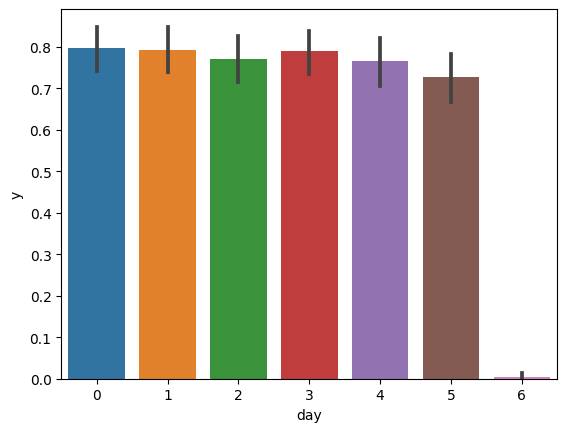

In [ ]:
sns.barplot(x="day", y="y", data=current_target_data)

<Axes: xlabel='month', ylabel='y'>

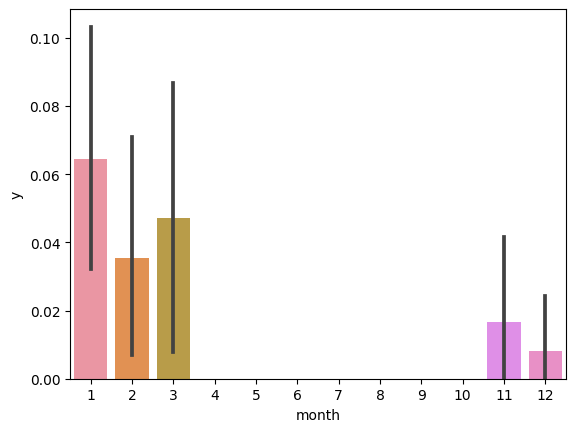

In [ ]:
sns.barplot(x="month", y="y", data=current_target_data)

### Prophet 하이퍼 파라미터 탐색

In [ ]:
search_data = prophet_train_data[prophet_train_data["ID"] == "TG_A_J"].drop(columns=["ID"]).sort_values("ds").copy()

In [ ]:
train_size = int(len(search_data) * 0.8)
search_train_data = search_data[:train_size]
# 만약 0을 제외하고 사용하려면 아래 줄 주석을 해제하세요
# search_train_data = search_train_data[search_train_data["y"] > 0]
search_test_data = search_data[train_size:]

In [ ]:
search_train_data

,ds,y
0,2019-01-01,0.0
1,2019-01-02,0.0
2,2019-01-03,1728.0
3,2019-01-04,1408.0
4,2019-01-05,1250.0
...,...,...
1213,2022-04-28,5508.0
1214,2022-04-29,5998.0
1215,2022-04-30,5415.0
1216,2022-05-01,0.0


In [ ]:
param_grid = {
    'growth': ['linear'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1, 5, 10],
    'seasonality_prior_scale': [0.01, 0.1, 1, 5, 10],
    'changepoint_range': [0.8, 0.85, 0.9, 0.95],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False],
    'holidays_prior_scale': [0.1, 1, 5],
}

In [ ]:
def prophet_grid_search(num_iterations, param_grid, train_data, y):
  results = []

  for _ in range(num_iterations) :
    random_params = {
        key : random.choice(value) for key, value in param_grid.items()
    }

    current_model = Prophet(**random_params)
    current_model.fit(train_data)

    y_size = len(y)

    future = current_model.make_future_dataframe(periods=y_size)
    forecast = current_model.predict(future)
    m_predict = forecast["yhat"].values[-y_size:]

    se = np.square(m_predict - y)
    rmse = np.sqrt(np.mean(se))

    results.append((random_params, rmse))
  return results


In [ ]:
model_per_category = {}
for category in category_list:
  search_data = prophet_train_data[prophet_train_data["ID"] == category].drop(columns=["ID"]).sort_values("ds").copy()
  train_size = int(len(search_data) * 0.8)
  search_train_data = search_data[:train_size]
  # 만약 0을 제외하고 사용하려면 아래 줄 주석을 해제하세요
  # search_train_data = search_train_data[search_train_data["y"] > 0]
  search_test_data = search_data[train_size:]
  y = search_test_data["y"].values[:]
  results = prophet_grid_search(20, param_grid, search_train_data, y)
  sorted_results = sorted(results, key=lambda x : x[1])[:5]
  model_per_category[category] = sorted_results

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjydeo82b/ok1ypriz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79426', 'data', 'file=/tmp/tmpjydeo82b/c7sovqn7.json', 'init=/tmp/tmpjydeo82b/ok1ypriz.json', 'output', 'file=/tmp/tmpjydeo82b/prophet_modelj7jw5hua/prophet_model-20231110151512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:15:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjydeo82b/kbdy82zv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjydeo82b/f6pbymzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-package

In [ ]:
test_result = model_per_category["TG_A_J"]

In [ ]:
best_params, best_rmse = min(test_result, key=lambda x: x[1])

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjydeo82b/p32f62mg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjydeo82b/hlvofh82.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36529', 'data', 'file=/tmp/tmpjydeo82b/p32f62mg.json', 'init=/tmp/tmpjydeo82b/hlvofh82.json', 'output', 'file=/tmp/tmpjydeo82b/prophet_modelv3co4bq_/prophet_model-20231110152446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:24:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:24:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


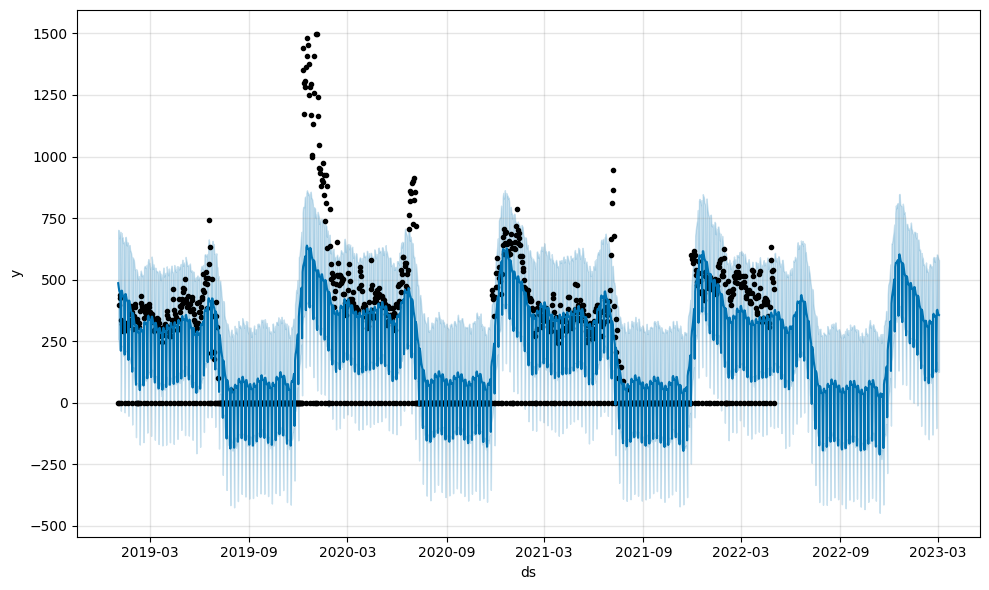

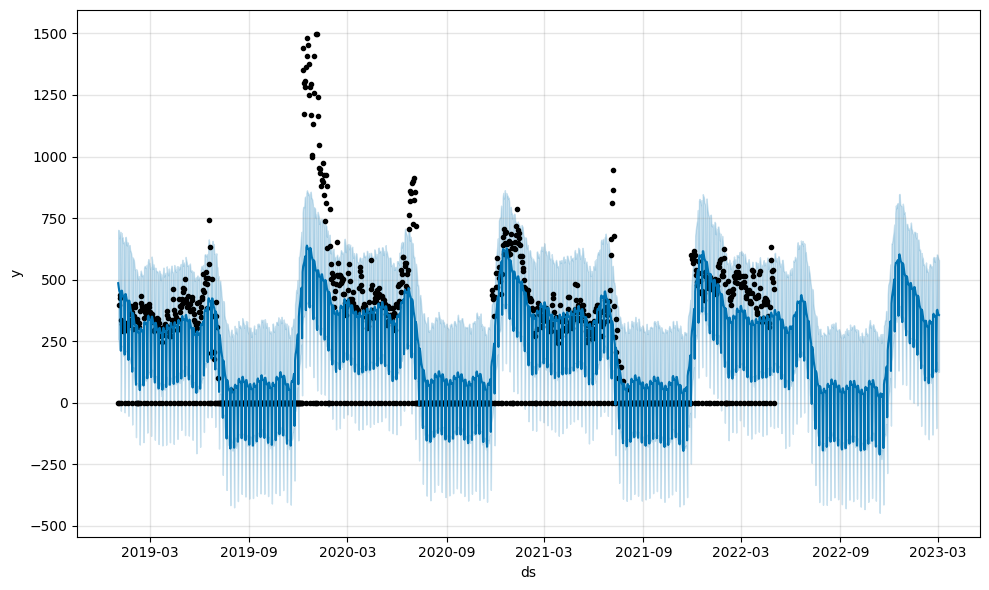

In [ ]:
test_model = Prophet(**best_params)
test_model.fit(search_train_data)
future = test_model.make_future_dataframe(periods=305)
forecast = test_model.predict(future)
test_model.plot(forecast)

In [ ]:
prophet_map = {}

In [ ]:
for category in category_list :
  category_prophet_result = model_per_category[category]
  best_params, best_rmse = min(category_prophet_result, key=lambda x: x[1])
  main_model = Prophet(
      **best_params
  )
  current_category_train_x = prophet_train_data[prophet_train_data["ID"] == category].drop(columns=["ID"]).sort_values("ds")
  prophet_map[category] = main_model.fit(current_category_train_x)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjydeo82b/stpc_oct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjydeo82b/mvyyco3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91484', 'data', 'file=/tmp/tmpjydeo82b/stpc_oct.json', 'init=/tmp/tmpjydeo82b/mvyyco3r.json', 'output', 'file=/tmp/tmpjydeo82b/prophet_modelpqnutgau/prophet_model-20231110152447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:24:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:24:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjydeo82b/adqwqvlt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjydeo82b/i2hyjene.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
test_df["price(원/kg)"] = 0

In [ ]:
prophet_test_data = handle_data_to_prophet(test_df)

In [ ]:
result_map = {}
for category in category_list :
  current_category_test_x = prophet_test_data[prophet_test_data["ID"] == category].drop(columns=["ID"])
  model = prophet_map[category]
  y = model.predict(current_category_test_x)
  result_map[category] = y["yhat"].values.tolist()

In [ ]:
copy_result_map = copy.deepcopy(result_map)

In [ ]:
def assign_result(row) :
  category = re.sub(r'_\d{8}$', '', row["ID"])
  result = copy_result_map[category]
  return result.pop(0)

In [ ]:
submission = pd.read_csv(sample_submission_path)

In [ ]:
submission.head()

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0


In [ ]:
submission["answer"] = 0

In [ ]:
submission["answer"] = submission.apply(assign_result, axis=1)

In [ ]:
submission.tail()

,ID,answer,timestamp,day of week
1087,RD_F_J_20230327,418.757426,2023-03-27,0
1088,RD_F_J_20230328,425.406551,2023-03-28,1
1089,RD_F_J_20230329,416.270635,2023-03-29,2
1090,RD_F_J_20230330,409.355464,2023-03-30,3
1091,RD_F_J_20230331,404.074682,2023-03-31,4


In [ ]:
holiday_test = ["2023-03-05","2023-03-12","2023-03-19","2023-03-26"]

In [ ]:
submission['timestamp'] = pd.to_datetime(submission['ID'].str.extract(r'(\d{4}\d{2}\d{2})')[0], format='%Y%m%d')
submission["day of week"] = submission["timestamp"].dt.dayofweek

In [ ]:
submission.loc[submission["day of week"] == 6, "answer"] = 0

In [ ]:
submission.loc[submission["timestamp"].isin(holiday_test), "answer"] = 0

In [ ]:
submission.loc[submission["answer"] < 0, "answer"] = 0

In [ ]:
submission[submission["day of week"] == 6]

,ID,answer,timestamp,day of week
1,TG_A_J_20230305,0.0,2023-03-05,6
8,TG_A_J_20230312,0.0,2023-03-12,6
15,TG_A_J_20230319,0.0,2023-03-19,6
22,TG_A_J_20230326,0.0,2023-03-26,6
29,TG_A_S_20230305,0.0,2023-03-05,6
...,...,...,...,...
1058,CB_F_J_20230326,0.0,2023-03-26,6
1065,RD_F_J_20230305,0.0,2023-03-05,6
1072,RD_F_J_20230312,0.0,2023-03-12,6
1079,RD_F_J_20230319,0.0,2023-03-19,6


In [ ]:
submission.drop(labels=["timestamp", "day of week"], axis=1,inplace=True)

In [ ]:
submission.tail(5)

,ID,answer
1087,RD_F_J_20230327,418.757426
1088,RD_F_J_20230328,425.406551
1089,RD_F_J_20230329,416.270635
1090,RD_F_J_20230330,409.355464
1091,RD_F_J_20230331,404.074682


In [ ]:
submission.to_csv(drive_path + "/submission_231110_1.csv", index=False)